In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import torchvision
import os
import shutil
%matplotlib inline

##### 创建图片分类文件夹

In [2]:
base_dir = r'./data/FourWeather'

In [3]:
if not os.path.isdir(base_dir):                #创建目录当且仅当目录不存在
    os.mkdir(base_dir)                         #创建存放不同种类数据的根目录
    train_dir = os.path.join(base_dir,"train") #在basedir里面添加train目录
    test_dir  = os.path.join(base_dir,"test")  #在basedir里面添加test目录
    os.mkdir(train_dir)
    os.mkdir(test_dir)

In [4]:
species = ['cloudy','rain','shine','sunrise']  #在不同子目录里面创建类别目录
for train_or_test in ['train','test']:
    for spec in species:
        if not os.path.exists(os.path.join(base_dir,train_or_test,spec)): # 创建目录当且仅当目录不存在
            os.mkdir(os.path.join(base_dir,train_or_test,spec))

##### 从dataset2中转移图片到data/FourWeather

In [5]:
image_dir = r"./data/dataset2"

In [6]:
for i,img in enumerate(os.listdir(image_dir)):
    for spec in species:
        if spec in img:                                            #判断满足条件下移动图片
            if i % 5 == 0:                                         #划分数据集
                s = os.path.join(image_dir,img)                    #原始图片的目录
                d = os.path.join(base_dir,"test",spec,img)         #图片的目标文件夹
            else:
                s = os.path.join(image_dir,img)                    #原始图片的目录
                d = os.path.join(base_dir,"train",spec,img)        #图片的目标文件夹
            shutil.copy(s,d)                                       #将图片从s拷贝到d中

In [7]:
#计算并打印天气数据集中每一种类型的子数据集各种天气数据各有多少条目
# for train_or_test in ['train','test']:
#     for spec in species:
#         print(train_or_test,"\n\t",spec,"\n\t\t",len(os.listdir(os.path.join(base_dir,train_or_test,spec))))
#     print("\n\n\n")

##### 读取图片数据

In [8]:
from torchvision import transforms

In [9]:
transform = transforms.Compose([                                    #设置对图片的转换
    transforms.Resize((96,96)),                                     #将不同大小图片转换为统一的大小
    transforms.ToTensor(),                                          #将channel放在前面，将数据归一化到(0,1)
    transforms.Normalize(mean=[0.5,0.5,0.5],std=[0.5,0.5,0.5])      #设置RGB形式的图像的均值和方差，标准化图像数据
])

In [10]:
train_ds = torchvision.datasets.ImageFolder(                        #从本地图片文件夹加载数据
    os.path.join(base_dir,"train"),                                 #在指定数据存储的文件夹
    transform = transform                                           #设定数据集中每一条数据需要做何种变换
)
test_ds = torchvision.datasets.ImageFolder(                         #从本地图片文件夹加载数据
    os.path.join(base_dir,"test"),                                  #在指定数据存储的文件夹
    transform = transform                                           #设定数据集中每一条数据需要做何种变换
)

In [11]:
test_ds.classes                                                     #classes属性用来表示数据集中都有哪些类型

['cloudy', 'rain', 'shine', 'sunrise']

In [12]:
test_ds.class_to_idx                                                #查看每一个分类的编号

{'cloudy': 0, 'rain': 1, 'shine': 2, 'sunrise': 3}

In [13]:
len(train_ds)                                                       #查看训练数据集的规模

900

In [14]:
len(test_ds)                                                        #查看测试数据集的规模

225

In [15]:
BATCH_SIZE = 16                                                

In [16]:
train_dl   = torch.utils.data.DataLoader(train_ds,batch_size=BATCH_SIZE,shuffle=True)
test_dl    = torch.utils.data.DataLoader( test_ds,batch_size=BATCH_SIZE,shuffle=True)

##### 查看数据集中的数据

In [17]:
imgs,labels = next(iter(train_dl))                                  # 很容易得出 imgs.shape的输出结果是(16,3,96,96) 参数含义 图片数量 每张图片通道数 图片宽度 图片高度

In [18]:
img = imgs[0].permute(1,2,0)                                        #交换图像通道 宽，高参数信息 以便使用其他工具绘制出图像

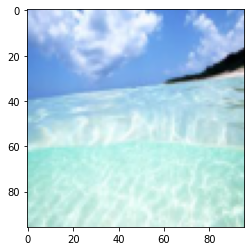

In [19]:
plt.imshow((img.numpy()+1)/2)                                       # 将标准化的图像复原并绘制图像

In [20]:
print(labels[0])                                                     # 得到图片对应的结果标签

tensor(2)


###### 为了方便对图片的类别做识别，这里设置一个字典用于将labels映射到不同的天气类型当中

In [21]:
train_ds.class_to_idx                                                # 查看类型与label对应关系

{'cloudy': 0, 'rain': 1, 'shine': 2, 'sunrise': 3}

In [22]:
id_to_class = dict((v,k) for k,v in train_ds.class_to_idx.items())

In [23]:
id_to_class

{0: 'cloudy', 1: 'rain', 2: 'shine', 3: 'sunrise'}

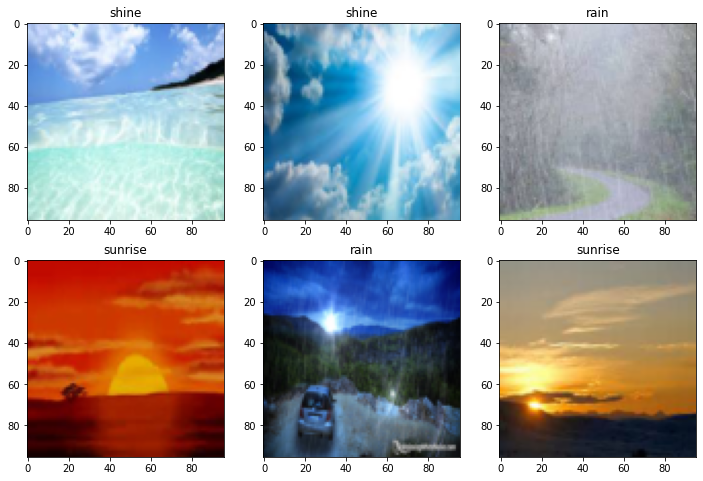

In [24]:
plt.figure(figsize=(12,8))
for i,(img,label) in enumerate(zip(imgs[:6],labels[:6])):
    img = (img.permute(1,2,0).numpy() + 1)/2                         # 规范化图像，并绘制       
    plt.subplot(2,3,i+1)
    plt.title(id_to_class.get(label.item()))                         #label.item()用于取出Tensor中的标量值
    plt.imshow(img)

##### 创建模型

In [25]:
class Net(nn.Module):
    # 三层卷积层 三层池化层 两层全连接层
    def __init__(self):                                               #使用VGG卷积核设置方法
        super(Net,self).__init__()                                    #继承父类的所有属性
        self.conv_1 = nn.Conv2d(3,16,(3,3))                           #输入图片通道数 卷积核数量 卷积核大小
        self.conv_2 = nn.Conv2d(16,32,(3,3))                          #输入图片通道数 卷积核数量 卷积核大小
        self.conv_3 = nn.Conv2d(32,64,(3,3))                          #输入图片通道数 卷积核数量 卷积核大小
        self.pool   = nn.MaxPool2d(2,2)
        self.linear_1 = nn.Linear(64*10*10,1024)                      #这里不使用公式计算线性层的输入 而采用随机编写最后修正的方法
        self.linear_2 = nn.Linear(1024,4)
    
    def forward(self,input):
        x = self.conv_1(input)
        x = F.relu(x)
        x = self.pool(x)
        x = self.conv_2(x)
        x = F.relu(x)
        x = self.pool(x)
        x = self.conv_3(x)
        x = F.relu(x)
        x = self.pool(x)
        #print(x.size())                                              #唯一不确定的内容                                           
        x = x.view(-1,x.size(1)*x.size(2)*x.size(3))                  #避免手动计算池化层的输出
        x = self.linear_1(x)
        x = F.relu(x)
        x = self.linear_2(x)
        return x

##### 尝试预测并得出结果(不经训练模型)

In [26]:
model = Net()

In [27]:
preds = model(imgs)                                                    #为了确定参数这里在第一次调用的时候会发生异常并显示一个torch.Size()对象的数值，将这个列表中的数值相乘填回linear_1的第一个参数中，并重新运行笔记本
print(imgs.shape)                                                      #输入数据的规模
print(preds.shape)                                                     #输出数据的规模
print(torch.argmax(preds,axis=1))                                      #展示预测结果

torch.Size([16, 3, 96, 96])
torch.Size([16, 4])
tensor([2, 0, 2, 0, 0, 0, 2, 0, 0, 2, 0, 0, 0, 0, 0, 0])


##### 训练模型

In [28]:
model               = Net().to("cuda")
loss_fn             = torch.nn.CrossEntropyLoss()      # 将损失函数定义为交叉熵函数
optim               = torch.optim.Adam(model.parameters(),lr = 0.0001)
epochs              = 20

In [29]:
train_loss = []
train_acc  = []
test_loss  = []
test_acc   = []

In [30]:
def fit(model,trainloader,testloader,epoch):
    correct = 0       # 记录正确率
    total   = 0       # 记录训练样本总数量
    running_loss = 0
    
    for x,y in trainloader:
        if torch.cuda.is_available():
            x,y = x.to("cuda"),y.to("cuda")
        y_pred = model(x)
        loss   = loss_fn(y_pred,y)
        optim.zero_grad()
        loss.backward()
        optim.step()
        with torch.no_grad():
            y_pred = torch.argmax(y_pred,dim=1)
            correct+=(y_pred == y).sum().item()
            total  += y.size(0)
            running_loss += loss.item()
    
    epoch_loss = running_loss / len(trainloader.dataset) # 得到每一个样本在本epoch下的平均loss
    epoch_acc  = correct / total # 得到整个样本的平均预测正确率
    
    test_correct      = 0       # 记录正确率
    test_total        = 0       # 记录训练样本总数量
    test_running_loss = 0
    
    with torch.no_grad():
        for x,y in trainloader:
            if torch.cuda.is_available():
                x,y = x.to("cuda"),y.to("cuda")
            y_pred = model(x)
            loss   = loss_fn(y_pred,y)
            y_pred = torch.argmax(y_pred,dim=1)
            test_correct+=(y_pred == y).sum().item()
            test_total  += y.size(0)
            test_running_loss += loss.item()
    
    epoch_test_loss = test_running_loss / len(testloader.dataset) # 得到每一个样本在本epoch下的平均loss
    epoch_test_acc  = test_correct / test_total # 得到整个样本的平均预测正确率
    
    print(
            "epoch:","\t",epoch,"\t",
            "loss: ","\t",round(epoch_loss,3),"\t",
            "accuracy: ","\t",round(epoch_acc,3),"\t",
            "test_loss: ","\t",round(epoch_test_loss,3),"\t",
            "test_accuracy: ","\t",round(epoch_test_acc,3),"\t"
        )
    return epoch_loss,epoch_acc,epoch_test_loss,epoch_test_acc

In [31]:
for epoch in range(epochs):
    epoch_loss,epoch_acc,epoch_test_loss,epoch_test_acc = fit(model,train_dl,test_dl,epoch)
    train_loss.append(epoch_loss)
    train_acc.append(epoch_acc)
    test_loss.append(epoch_test_loss)
    test_acc.append(epoch_test_acc)

epoch: 	 0 	 loss:  	 0.066 	 accuracy:  	 0.544 	 test_loss:  	 0.176 	 test_accuracy:  	 0.747 	
epoch: 	 1 	 loss:  	 0.039 	 accuracy:  	 0.77 	 test_loss:  	 0.133 	 test_accuracy:  	 0.792 	
epoch: 	 2 	 loss:  	 0.028 	 accuracy:  	 0.844 	 test_loss:  	 0.103 	 test_accuracy:  	 0.844 	
epoch: 	 3 	 loss:  	 0.025 	 accuracy:  	 0.85 	 test_loss:  	 0.091 	 test_accuracy:  	 0.879 	
epoch: 	 4 	 loss:  	 0.023 	 accuracy:  	 0.874 	 test_loss:  	 0.09 	 test_accuracy:  	 0.857 	
epoch: 	 5 	 loss:  	 0.021 	 accuracy:  	 0.873 	 test_loss:  	 0.085 	 test_accuracy:  	 0.869 	
epoch: 	 6 	 loss:  	 0.02 	 accuracy:  	 0.876 	 test_loss:  	 0.072 	 test_accuracy:  	 0.891 	
epoch: 	 7 	 loss:  	 0.019 	 accuracy:  	 0.894 	 test_loss:  	 0.068 	 test_accuracy:  	 0.901 	
epoch: 	 8 	 loss:  	 0.017 	 accuracy:  	 0.904 	 test_loss:  	 0.062 	 test_accuracy:  	 0.917 	
epoch: 	 9 	 loss:  	 0.016 	 accuracy:  	 0.908 	 test_loss:  	 0.058 	 test_accuracy:  	 0.924 	
epoch: 	 10 	 

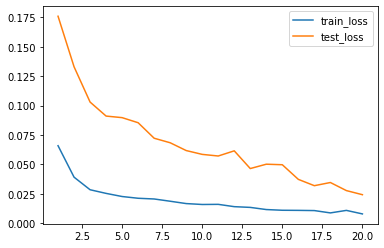

In [32]:
plt.plot(range(1,epochs+1),train_loss,label = "train_loss")
plt.plot(range(1,epochs+1),test_loss,label = "test_loss")
plt.legend()

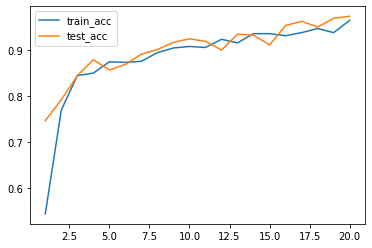

In [33]:
plt.plot(range(1, epochs+1), train_acc, label='train_acc')
plt.plot(range(1, epochs+1), test_acc, label='test_acc')
plt.legend()